# PointPillars

In [1]:
import os
import time
import numpy as np
from glob import glob
from config import Parameters
from loss import PointPillarNetworkLoss
# from new_loss import PointPillarNetworkLoss
from processors import SimpleDataGenerator
from readers import KittiDataReader
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from inference_utils import generate_bboxes_from_pred, GroundTruthGenerator, focal_loss_checker, rotational_nms


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal


physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
K.clear_session()

def enable_amp():
    mixed_precision.set_global_policy("mixed_float16")
    
print("Tensorflow version: ", tf.__version__)
print(physical_devices,"\n")
enable_amp()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/fixes.py:28: UserWarning: Module point_pillars was already imported from /usr/local/lib/python3.6/dist-packages/point_pillars-0.0.1-py3.6-linux-x86_64.egg/point_pillars.cpython-36m-x86_64-linux-gnu.so, but /tf/PythonProjects/object_detection/PointPillars is being added to sys.path
  from pkg_resources import parse_version  # type: ignore


Tensorflow version:  2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


In [2]:
DATA_ROOT = "../kitti_dataset/training"  # TODO make main arg
MODEL_ROOT = "./logs"

In [3]:
def build_point_pillar_graph(params: Parameters):

    # extract required parameters
    max_pillars = int(params.max_pillars)
    max_points  = int(params.max_points_per_pillar)
    nb_features = int(params.nb_features)
    nb_channels = int(params.nb_channels)
    batch_size  = int(params.batch_size)
    image_size  = tuple([params.Xn, params.Yn])
    nb_classes  = int(params.nb_classes)
    nb_anchors  = len(params.anchor_dims)
    S1 = (1,1); S2 = (2,2); S3 = (3,3); S4 = (4,4)
    K1 = (1,1); K3 = (3,3)

    if K.image_data_format() == "channels_first":
        raise NotImplementedError
    else:
        input_shape = (max_pillars, max_points, nb_features)

    input_pillars = Input(input_shape, batch_size=batch_size, name="pillars/input")
    input_indices = Input((max_pillars, 3), batch_size=batch_size, name="pillars/indices", dtype=tf.int32)

    def correct_batch_indices(tensor, batch_size):
        array = np.zeros((batch_size, max_pillars, 3), dtype=np.float32)
        for i in range(batch_size):
            array[i, :, 0] = i
        return tensor + tf.constant(array, dtype=tf.int32)

    if batch_size > 1:
        corrected_indices = Lambda(lambda t: correct_batch_indices(t, batch_size))(input_indices)
    else:
        corrected_indices = input_indices

    # pillars
    x = Conv2D(nb_channels, (1, 1), activation='linear', use_bias=False, name="pillars/conv2d")(input_pillars)
    x = BatchNormalization(name="pillars/batchnorm", fused=True, epsilon=1e-3, momentum=0.99)(x)
    x = Activation("relu", name="pillars/relu")(x)
    x = MaxPool2D((1, max_points), name="pillars/maxpooling2d")(x)

    if K.image_data_format() == "channels_first":
        reshape_shape = (nb_channels, max_pillars)
    else:
        reshape_shape = (max_pillars, nb_channels)

    x = Reshape(reshape_shape, name="pillars/reshape")(x)
    pillars = Lambda(
        lambda inp: tf.scatter_nd(inp[0], inp[1],(batch_size,) + image_size + (nb_channels,)),
        name="pillars/scatter_nd"
    )([corrected_indices, x])

    # 2d cnn backbone

    # Block1(S, 4, C)
    x = pillars
    for n in range(4):
        S = (2, 2) if n == 0 else (1, 1)
        x = Conv2D(nb_channels,K3, strides=S, padding="same", activation="relu", name="cnn/block1/conv2d%i"%n)(x)
        x = BatchNormalization(name="cnn/block1/bn%i" % n, fused=True)(x)
    x1 = x

    # Block2(2S, 6, 2C)
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = Conv2D(2*nb_channels,K3, strides=S, padding="same",activation="relu",name="cnn/block2/conv2d%i"%n)(x)
        x = BatchNormalization(name="cnn/block2/bn%i" % n, fused=True)(x)
    x2 = x

    # Block3(4S, 6, 4C)
    for n in range(6):
        S = (2, 2) if n == 0 else (1, 1)
        x = Conv2D(2*nb_channels,K3, strides=S, padding="same", activation="relu",name="cnn/block3/conv2d%i"%n)(x)
        x = BatchNormalization(name="cnn/block3/bn%i" % n, fused=True)(x)
    x3 = x

    # Up1 (S, S, 2C)
    up1 = Conv2DTranspose(2*nb_channels,K3,strides=S1,padding="same",activation="relu",name="cnn/up1/conv2dt")(x1)
    up1 = BatchNormalization(name="cnn/up1/bn", fused=True)(up1)

    # Up2 (2S, S, 2C)
    up2 = Conv2DTranspose(2*nb_channels,K3,strides=S2,padding="same",activation="relu",name="cnn/up2/conv2dt")(x2)
    up2 = BatchNormalization(name="cnn/up2/bn", fused=True)(up2)

    # Up3 (4S, S, 2C)
    up3 = Conv2DTranspose(2*nb_channels,K3,strides=S4,padding="same",activation="relu",name="cnn/up3/conv2dt")(x3)
    up3 = BatchNormalization(name="cnn/up3/bn", fused=True)(up3)

    # Concat
    concat = Concatenate(name="cnn/concatenate")([up1, up2, up3])

    # Detection head
    occ = Conv2D(nb_anchors, (1, 1), name="occupancy/conv2d", activation="sigmoid", dtype="float32")(concat)

    loc = Conv2D(nb_anchors*3, K1, name="loc/conv2d", kernel_initializer=TruncatedNormal(0, 0.001), dtype="float32")(concat)
    loc = Reshape(tuple(i//2 for i in image_size) + (nb_anchors, 3), name="loc/reshape", dtype="float32")(loc)

    size = Conv2D(nb_anchors*3, (1, 1), name="size/conv2d", kernel_initializer=TruncatedNormal(0, 0.001), dtype="float32")(concat)
    size = Reshape(tuple(i//2 for i in image_size) + (nb_anchors, 3), name="size/reshape", dtype="float32")(size)

    angle = Conv2D(nb_anchors, (1, 1), name="angle/conv2d", dtype="float32")(concat)

    heading = Conv2D(nb_anchors, (1, 1), name="heading/conv2d", activation="sigmoid", dtype="float32")(concat)

    clf = Conv2D(nb_anchors * nb_classes, (1, 1), name="clf/conv2d", dtype="float32")(concat)
    clf = Reshape(tuple(i//2 for i in image_size)+(nb_anchors,nb_classes),name="clf/reshape",dtype="float32")(clf)

    pillar_net = tf.keras.models.Model([input_pillars, input_indices], [occ, loc, size, angle, heading, clf])

    return pillar_net

In [4]:
params = Parameters()

In [5]:
pillar_net = build_point_pillar_graph(params)

In [6]:
# plot_model(pillar_net, show_shapes=True, dpi=100)

In [10]:
pillar_net.load_weights(os.path.join(MODEL_ROOT, "model_v2.h5"))

In [11]:
loss = PointPillarNetworkLoss(params)

optimizer = Adam(lr=params.learning_rate, decay=params.decay_rate)

pillar_net.compile(optimizer, loss=loss.losses())

data_reader = KittiDataReader()

In [12]:
lidar_files = sorted(glob(os.path.join(DATA_ROOT, "velodyne", "*.bin")))
label_files = sorted(glob(os.path.join(DATA_ROOT, "label_2", "*.txt")))
calibration_files = sorted(glob(os.path.join(DATA_ROOT, "calib", "*.txt")))
validation_len = int(0.3*len(label_files))

In [13]:
training_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[:-validation_len], 
    label_files[:-validation_len], 
    calibration_files[:-validation_len]
)

validation_gen = SimpleDataGenerator(
    data_reader, 
    params.batch_size, 
    lidar_files[-validation_len:], 
    label_files[-validation_len:], 
    calibration_files[-validation_len:]
)

In [14]:
log_dir = MODEL_ROOT
ckpt_path = os.path.join(log_dir, "model_v3.h5")

epoch_to_decay = int(
    np.round(params.iters_to_decay/params.batch_size*int(np.ceil(float(len(label_files))/params.batch_size)))
)

In [15]:
callbacks = [
    ModelCheckpoint(filepath=ckpt_path, monitor='loss', save_best_only=True),
    LearningRateScheduler(
        lambda epoch, lr: lr * 0.8 if ((epoch % epoch_to_decay == 0) and (epoch != 0)) else lr, verbose=True),
    EarlyStopping(patience=20, monitor='loss'),
]

In [16]:
results = pillar_net.fit(
    training_gen,
    validation_data = validation_gen,
    steps_per_epoch=len(training_gen),
    callbacks=callbacks,
    use_multiprocessing=True,
    epochs=int(params.total_training_epochs),
    workers=8
)

Epoch 1/160

Epoch 00001: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 711s 533ms/step - loss: 0.0729 - occupancy/conv2d_loss: 0.0016 - loc/reshape_loss: 0.0101 - size/reshape_loss: 0.0096 - angle/conv2d_loss: 0.0069 - heading/conv2d_loss: 0.0386 - clf/reshape_loss: 0.0062 - val_loss: 0.1875 - val_occupancy/conv2d_loss: 0.0016 - val_loc/reshape_loss: 0.0115 - val_size/reshape_loss: 0.0106 - val_angle/conv2d_loss: 0.0097 - val_heading/conv2d_loss: 0.1086 - val_clf/reshape_loss: 0.0455
Epoch 2/160

Epoch 00002: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 705s 536ms/step - loss: 0.0619 - occupancy/conv2d_loss: 0.0015 - loc/reshape_loss: 0.0098 - size/reshape_loss: 0.0090 - angle/conv2d_loss: 0.0058 - heading/conv2d_loss: 0.0300 - clf/reshape_loss: 0.0056 - val_loss: 0.1987 - val_occupancy/conv2d_loss: 0.0016 - val_loc/reshape_loss: 0.0104 - val_s

Epoch 6/160

Epoch 00006: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 546ms/step - loss: 0.0436 - occupancy/conv2d_loss: 0.0015 - loc/reshape_loss: 0.0085 - size/reshape_loss: 0.0081 - angle/conv2d_loss: 0.0048 - heading/conv2d_loss: 0.0173 - clf/reshape_loss: 0.0034 - val_loss: 0.2013 - val_occupancy/conv2d_loss: 0.0016 - val_loc/reshape_loss: 0.0111 - val_size/reshape_loss: 0.0102 - val_angle/conv2d_loss: 0.0087 - val_heading/conv2d_loss: 0.1166 - val_clf/reshape_loss: 0.0532
Epoch 7/160

Epoch 00007: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 718s 546ms/step - loss: 0.0417 - occupancy/conv2d_loss: 0.0015 - loc/reshape_loss: 0.0081 - size/reshape_loss: 0.0080 - angle/conv2d_loss: 0.0045 - heading/conv2d_loss: 0.0161 - clf/reshape_loss: 0.0034 - val_loss: 0.2324 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0181 - val_s

Epoch 11/160

Epoch 00011: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 711s 542ms/step - loss: 0.0376 - occupancy/conv2d_loss: 0.0015 - loc/reshape_loss: 0.0084 - size/reshape_loss: 0.0074 - angle/conv2d_loss: 0.0041 - heading/conv2d_loss: 0.0126 - clf/reshape_loss: 0.0036 - val_loss: 0.2450 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0117 - val_size/reshape_loss: 0.0099 - val_angle/conv2d_loss: 0.0086 - val_heading/conv2d_loss: 0.1648 - val_clf/reshape_loss: 0.0484
Epoch 12/160

Epoch 00012: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 729s 553ms/step - loss: 0.0321 - occupancy/conv2d_loss: 0.0015 - loc/reshape_loss: 0.0077 - size/reshape_loss: 0.0071 - angle/conv2d_loss: 0.0037 - heading/conv2d_loss: 0.0102 - clf/reshape_loss: 0.0019 - val_loss: 0.2474 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0106 - val

Epoch 16/160

Epoch 00016: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 720s 546ms/step - loss: 0.0258 - occupancy/conv2d_loss: 0.0014 - loc/reshape_loss: 0.0069 - size/reshape_loss: 0.0066 - angle/conv2d_loss: 0.0032 - heading/conv2d_loss: 0.0060 - clf/reshape_loss: 0.0017 - val_loss: 0.2537 - val_occupancy/conv2d_loss: 0.0016 - val_loc/reshape_loss: 0.0119 - val_size/reshape_loss: 0.0130 - val_angle/conv2d_loss: 0.0085 - val_heading/conv2d_loss: 0.1560 - val_clf/reshape_loss: 0.0626
Epoch 17/160

Epoch 00017: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 712s 542ms/step - loss: 0.0303 - occupancy/conv2d_loss: 0.0014 - loc/reshape_loss: 0.0073 - size/reshape_loss: 0.0070 - angle/conv2d_loss: 0.0034 - heading/conv2d_loss: 0.0087 - clf/reshape_loss: 0.0024 - val_loss: 0.3007 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0201 - val

Epoch 21/160

Epoch 00021: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 544ms/step - loss: 0.0286 - occupancy/conv2d_loss: 0.0014 - loc/reshape_loss: 0.0067 - size/reshape_loss: 0.0065 - angle/conv2d_loss: 0.0032 - heading/conv2d_loss: 0.0064 - clf/reshape_loss: 0.0045 - val_loss: 0.2676 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0125 - val_size/reshape_loss: 0.0110 - val_angle/conv2d_loss: 0.0081 - val_heading/conv2d_loss: 0.1742 - val_clf/reshape_loss: 0.0604
Epoch 22/160

Epoch 00022: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 714s 542ms/step - loss: 0.0243 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0063 - size/reshape_loss: 0.0063 - angle/conv2d_loss: 0.0031 - heading/conv2d_loss: 0.0053 - clf/reshape_loss: 0.0019 - val_loss: 0.3132 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0134 - val

Epoch 26/160

Epoch 00026: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 712s 541ms/step - loss: 0.0230 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0060 - size/reshape_loss: 0.0059 - angle/conv2d_loss: 0.0025 - heading/conv2d_loss: 0.0058 - clf/reshape_loss: 0.0014 - val_loss: 0.3820 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0140 - val_size/reshape_loss: 0.0140 - val_angle/conv2d_loss: 0.0082 - val_heading/conv2d_loss: 0.1470 - val_clf/reshape_loss: 0.1973
Epoch 27/160

Epoch 00027: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 717s 544ms/step - loss: 0.0242 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0059 - size/reshape_loss: 0.0059 - angle/conv2d_loss: 0.0028 - heading/conv2d_loss: 0.0066 - clf/reshape_loss: 0.0017 - val_loss: 0.2471 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0110 - val

Epoch 31/160

Epoch 00031: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 714s 544ms/step - loss: 0.0209 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0054 - size/reshape_loss: 0.0054 - angle/conv2d_loss: 0.0024 - heading/conv2d_loss: 0.0051 - clf/reshape_loss: 0.0013 - val_loss: 0.2548 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0101 - val_size/reshape_loss: 0.0090 - val_angle/conv2d_loss: 0.0072 - val_heading/conv2d_loss: 0.1656 - val_clf/reshape_loss: 0.0614
Epoch 32/160

Epoch 00032: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 718s 546ms/step - loss: 0.0155 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0047 - size/reshape_loss: 0.0049 - angle/conv2d_loss: 0.0020 - heading/conv2d_loss: 0.0018 - clf/reshape_loss: 8.1221e-04 - val_loss: 0.2847 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0109 -

Epoch 36/160

Epoch 00036: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 733s 557ms/step - loss: 0.0226 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0051 - size/reshape_loss: 0.0050 - angle/conv2d_loss: 0.0023 - heading/conv2d_loss: 0.0081 - clf/reshape_loss: 8.9878e-04 - val_loss: 0.2912 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0187 - val_size/reshape_loss: 0.0093 - val_angle/conv2d_loss: 0.0084 - val_heading/conv2d_loss: 0.1905 - val_clf/reshape_loss: 0.0628
Epoch 37/160

Epoch 00037: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 722s 547ms/step - loss: 0.0188 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0047 - size/reshape_loss: 0.0050 - angle/conv2d_loss: 0.0021 - heading/conv2d_loss: 0.0046 - clf/reshape_loss: 0.0011 - val_loss: 0.2866 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0183 -

Epoch 41/160

Epoch 00041: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 712s 541ms/step - loss: 0.0159 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0043 - size/reshape_loss: 0.0045 - angle/conv2d_loss: 0.0018 - heading/conv2d_loss: 0.0029 - clf/reshape_loss: 0.0011 - val_loss: 0.3131 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0161 - val_size/reshape_loss: 0.0094 - val_angle/conv2d_loss: 0.0090 - val_heading/conv2d_loss: 0.1932 - val_clf/reshape_loss: 0.0841
Epoch 42/160

Epoch 00042: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 717s 543ms/step - loss: 0.0250 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0049 - size/reshape_loss: 0.0049 - angle/conv2d_loss: 0.0022 - heading/conv2d_loss: 0.0062 - clf/reshape_loss: 0.0055 - val_loss: 0.2781 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0194 - val

Epoch 46/160

Epoch 00046: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 547ms/step - loss: 0.0173 - occupancy/conv2d_loss: 0.0013 - loc/reshape_loss: 0.0043 - size/reshape_loss: 0.0046 - angle/conv2d_loss: 0.0020 - heading/conv2d_loss: 0.0039 - clf/reshape_loss: 0.0012 - val_loss: 0.2761 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0107 - val_size/reshape_loss: 0.0124 - val_angle/conv2d_loss: 0.0068 - val_heading/conv2d_loss: 0.1730 - val_clf/reshape_loss: 0.0718
Epoch 47/160

Epoch 00047: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 715s 543ms/step - loss: 0.0152 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0040 - size/reshape_loss: 0.0045 - angle/conv2d_loss: 0.0017 - heading/conv2d_loss: 0.0025 - clf/reshape_loss: 0.0012 - val_loss: 0.2548 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0086 - val

Epoch 51/160

Epoch 00051: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 715s 541ms/step - loss: 0.0166 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0040 - size/reshape_loss: 0.0042 - angle/conv2d_loss: 0.0017 - heading/conv2d_loss: 0.0038 - clf/reshape_loss: 0.0017 - val_loss: 0.2915 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0115 - val_size/reshape_loss: 0.0123 - val_angle/conv2d_loss: 0.0069 - val_heading/conv2d_loss: 0.1755 - val_clf/reshape_loss: 0.0840
Epoch 52/160

Epoch 00052: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 711s 541ms/step - loss: 0.0160 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0041 - size/reshape_loss: 0.0044 - angle/conv2d_loss: 0.0018 - heading/conv2d_loss: 0.0034 - clf/reshape_loss: 0.0011 - val_loss: 0.2912 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0104 - val

Epoch 56/160

Epoch 00056: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 722s 548ms/step - loss: 0.0140 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0036 - size/reshape_loss: 0.0038 - angle/conv2d_loss: 0.0015 - heading/conv2d_loss: 0.0029 - clf/reshape_loss: 9.7599e-04 - val_loss: 0.2660 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0145 - val_size/reshape_loss: 0.0086 - val_angle/conv2d_loss: 0.0072 - val_heading/conv2d_loss: 0.1748 - val_clf/reshape_loss: 0.0594
Epoch 57/160

Epoch 00057: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 713s 542ms/step - loss: 0.0150 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0037 - size/reshape_loss: 0.0041 - angle/conv2d_loss: 0.0016 - heading/conv2d_loss: 0.0032 - clf/reshape_loss: 0.0011 - val_loss: 0.2612 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0085 -

Epoch 61/160

Epoch 00061: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 717s 545ms/step - loss: 0.0109 - occupancy/conv2d_loss: 0.0011 - loc/reshape_loss: 0.0030 - size/reshape_loss: 0.0033 - angle/conv2d_loss: 0.0013 - heading/conv2d_loss: 0.0012 - clf/reshape_loss: 9.5921e-04 - val_loss: 0.4361 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0146 - val_size/reshape_loss: 0.0129 - val_angle/conv2d_loss: 0.0077 - val_heading/conv2d_loss: 0.1828 - val_clf/reshape_loss: 0.2167
Epoch 62/160

Epoch 00062: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 543ms/step - loss: 0.0188 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0041 - size/reshape_loss: 0.0042 - angle/conv2d_loss: 0.0020 - heading/conv2d_loss: 0.0064 - clf/reshape_loss: 0.0010 - val_loss: 0.2484 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0088 -

Epoch 66/160

Epoch 00066: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 544ms/step - loss: 0.0118 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0032 - size/reshape_loss: 0.0036 - angle/conv2d_loss: 0.0014 - heading/conv2d_loss: 0.0016 - clf/reshape_loss: 8.5282e-04 - val_loss: 0.3297 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0094 - val_size/reshape_loss: 0.0097 - val_angle/conv2d_loss: 0.0065 - val_heading/conv2d_loss: 0.1800 - val_clf/reshape_loss: 0.1228
Epoch 67/160

Epoch 00067: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 718s 545ms/step - loss: 0.0116 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0031 - size/reshape_loss: 0.0034 - angle/conv2d_loss: 0.0013 - heading/conv2d_loss: 0.0017 - clf/reshape_loss: 9.8625e-04 - val_loss: 0.2632 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.00

Epoch 71/160

Epoch 00071: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 720s 545ms/step - loss: 0.0106 - occupancy/conv2d_loss: 0.0011 - loc/reshape_loss: 0.0028 - size/reshape_loss: 0.0032 - angle/conv2d_loss: 0.0012 - heading/conv2d_loss: 0.0014 - clf/reshape_loss: 8.4957e-04 - val_loss: 0.4202 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0141 - val_size/reshape_loss: 0.0112 - val_angle/conv2d_loss: 0.0074 - val_heading/conv2d_loss: 0.2027 - val_clf/reshape_loss: 0.1835
Epoch 72/160

Epoch 00072: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 542ms/step - loss: 0.0184 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0038 - size/reshape_loss: 0.0039 - angle/conv2d_loss: 0.0016 - heading/conv2d_loss: 0.0044 - clf/reshape_loss: 0.0034 - val_loss: 0.3397 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0103 -

Epoch 76/160

Epoch 00076: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 714s 543ms/step - loss: 0.0099 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0026 - size/reshape_loss: 0.0028 - angle/conv2d_loss: 0.0010 - heading/conv2d_loss: 0.0018 - clf/reshape_loss: 5.7608e-04 - val_loss: 0.2626 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0166 - val_size/reshape_loss: 0.0091 - val_angle/conv2d_loss: 0.0070 - val_heading/conv2d_loss: 0.1703 - val_clf/reshape_loss: 0.0582
Epoch 77/160

Epoch 00077: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 712s 541ms/step - loss: 0.0150 - occupancy/conv2d_loss: 0.0012 - loc/reshape_loss: 0.0035 - size/reshape_loss: 0.0035 - angle/conv2d_loss: 0.0015 - heading/conv2d_loss: 0.0044 - clf/reshape_loss: 9.4785e-04 - val_loss: 0.2446 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.00

Epoch 81/160

Epoch 00081: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 545ms/step - loss: 0.0108 - occupancy/conv2d_loss: 0.0011 - loc/reshape_loss: 0.0028 - size/reshape_loss: 0.0031 - angle/conv2d_loss: 0.0012 - heading/conv2d_loss: 0.0018 - clf/reshape_loss: 9.5188e-04 - val_loss: 0.9477 - val_occupancy/conv2d_loss: 0.0014 - val_loc/reshape_loss: 0.0238 - val_size/reshape_loss: 0.0305 - val_angle/conv2d_loss: 0.0090 - val_heading/conv2d_loss: 0.2026 - val_clf/reshape_loss: 0.6804
Epoch 82/160

Epoch 00082: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 718s 544ms/step - loss: 0.0113 - occupancy/conv2d_loss: 0.0011 - loc/reshape_loss: 0.0028 - size/reshape_loss: 0.0030 - angle/conv2d_loss: 0.0012 - heading/conv2d_loss: 0.0025 - clf/reshape_loss: 6.7265e-04 - val_loss: 0.5512 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.01

Epoch 86/160

Epoch 00086: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 711s 541ms/step - loss: 0.0085 - occupancy/conv2d_loss: 0.0011 - loc/reshape_loss: 0.0023 - size/reshape_loss: 0.0026 - angle/conv2d_loss: 8.8159e-04 - heading/conv2d_loss: 9.5639e-04 - clf/reshape_loss: 6.0185e-04 - val_loss: 0.2544 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0078 - val_size/reshape_loss: 0.0068 - val_angle/conv2d_loss: 0.0062 - val_heading/conv2d_loss: 0.1853 - val_clf/reshape_loss: 0.0470
Epoch 87/160

Epoch 00087: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 543ms/step - loss: 0.0081 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0021 - size/reshape_loss: 0.0024 - angle/conv2d_loss: 8.5690e-04 - heading/conv2d_loss: 9.7107e-04 - clf/reshape_loss: 7.1908e-04 - val_loss: 0.2472 - val_occupancy/conv2d_loss: 0.0012 - val_loc/re

Epoch 91/160

Epoch 00091: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 715s 544ms/step - loss: 0.0085 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0022 - size/reshape_loss: 0.0025 - angle/conv2d_loss: 7.8469e-04 - heading/conv2d_loss: 0.0011 - clf/reshape_loss: 9.7634e-04 - val_loss: 1.0993 - val_occupancy/conv2d_loss: 0.0015 - val_loc/reshape_loss: 0.0377 - val_size/reshape_loss: 0.0294 - val_angle/conv2d_loss: 0.0101 - val_heading/conv2d_loss: 0.2079 - val_clf/reshape_loss: 0.8128
Epoch 92/160

Epoch 00092: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 714s 542ms/step - loss: 0.0143 - occupancy/conv2d_loss: 0.0011 - loc/reshape_loss: 0.0031 - size/reshape_loss: 0.0031 - angle/conv2d_loss: 0.0013 - heading/conv2d_loss: 0.0043 - clf/reshape_loss: 0.0014 - val_loss: 0.2508 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.00

Epoch 96/160

Epoch 00096: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 720s 545ms/step - loss: 0.0080 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0021 - size/reshape_loss: 0.0024 - angle/conv2d_loss: 8.0462e-04 - heading/conv2d_loss: 0.0010 - clf/reshape_loss: 5.5666e-04 - val_loss: 0.2615 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0082 - val_size/reshape_loss: 0.0073 - val_angle/conv2d_loss: 0.0060 - val_heading/conv2d_loss: 0.1823 - val_clf/reshape_loss: 0.0563
Epoch 97/160

Epoch 00097: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 726s 552ms/step - loss: 0.0085 - occupancy/conv2d_loss: 9.9610e-04 - loc/reshape_loss: 0.0021 - size/reshape_loss: 0.0024 - angle/conv2d_loss: 8.6166e-04 - heading/conv2d_loss: 0.0015 - clf/reshape_loss: 6.2911e-04 - val_loss: 0.2600 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshap

Epoch 101/160

Epoch 00101: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 544ms/step - loss: 0.0091 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0023 - size/reshape_loss: 0.0025 - angle/conv2d_loss: 8.7953e-04 - heading/conv2d_loss: 0.0018 - clf/reshape_loss: 6.1949e-04 - val_loss: 0.2605 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0078 - val_size/reshape_loss: 0.0070 - val_angle/conv2d_loss: 0.0063 - val_heading/conv2d_loss: 0.1874 - val_clf/reshape_loss: 0.0508
Epoch 102/160

Epoch 00102: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 546ms/step - loss: 0.0095 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0023 - size/reshape_loss: 0.0024 - angle/conv2d_loss: 8.5238e-04 - heading/conv2d_loss: 0.0022 - clf/reshape_loss: 8.0218e-04 - val_loss: 0.2679 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_

Epoch 106/160

Epoch 00106: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 543ms/step - loss: 0.0082 - occupancy/conv2d_loss: 0.0010 - loc/reshape_loss: 0.0021 - size/reshape_loss: 0.0023 - angle/conv2d_loss: 7.5686e-04 - heading/conv2d_loss: 0.0013 - clf/reshape_loss: 7.5648e-04 - val_loss: 0.2606 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0078 - val_size/reshape_loss: 0.0067 - val_angle/conv2d_loss: 0.0059 - val_heading/conv2d_loss: 0.1870 - val_clf/reshape_loss: 0.0519
Epoch 107/160

Epoch 00107: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 716s 544ms/step - loss: 0.0081 - occupancy/conv2d_loss: 9.6904e-04 - loc/reshape_loss: 0.0021 - size/reshape_loss: 0.0022 - angle/conv2d_loss: 6.9027e-04 - heading/conv2d_loss: 0.0012 - clf/reshape_loss: 0.0010 - val_loss: 0.2527 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_

1309/1309 [==============================] - 721s 549ms/step - loss: 0.0091 - occupancy/conv2d_loss: 9.9476e-04 - loc/reshape_loss: 0.0022 - size/reshape_loss: 0.0024 - angle/conv2d_loss: 8.7115e-04 - heading/conv2d_loss: 0.0016 - clf/reshape_loss: 9.3626e-04 - val_loss: 0.2544 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0080 - val_size/reshape_loss: 0.0069 - val_angle/conv2d_loss: 0.0061 - val_heading/conv2d_loss: 0.1847 - val_clf/reshape_loss: 0.0476
Epoch 111/160

Epoch 00111: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 720s 548ms/step - loss: 0.0075 - occupancy/conv2d_loss: 9.8424e-04 - loc/reshape_loss: 0.0020 - size/reshape_loss: 0.0022 - angle/conv2d_loss: 7.1176e-04 - heading/conv2d_loss: 8.9634e-04 - clf/reshape_loss: 7.2366e-04 - val_loss: 0.3406 - val_occupancy/conv2d_loss: 0.0013 - val_loc/reshape_loss: 0.0095 - val_size/reshape_loss: 0.0097 - val_angle/conv2d_loss: 0.0063 - val_headi

1309/1309 [==============================] - 722s 548ms/step - loss: 0.0071 - occupancy/conv2d_loss: 9.5506e-04 - loc/reshape_loss: 0.0019 - size/reshape_loss: 0.0020 - angle/conv2d_loss: 6.3494e-04 - heading/conv2d_loss: 9.9883e-04 - clf/reshape_loss: 6.4113e-04 - val_loss: 0.2475 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0076 - val_size/reshape_loss: 0.0068 - val_angle/conv2d_loss: 0.0060 - val_heading/conv2d_loss: 0.1819 - val_clf/reshape_loss: 0.0439
Epoch 116/160

Epoch 00116: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 714s 542ms/step - loss: 0.0067 - occupancy/conv2d_loss: 9.4923e-04 - loc/reshape_loss: 0.0018 - size/reshape_loss: 0.0019 - angle/conv2d_loss: 5.8251e-04 - heading/conv2d_loss: 8.0239e-04 - clf/reshape_loss: 7.3651e-04 - val_loss: 0.2483 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0075 - val_size/reshape_loss: 0.0066 - val_angle/conv2d_loss: 0.0058 - val_h

1309/1309 [==============================] - 720s 546ms/step - loss: 0.0065 - occupancy/conv2d_loss: 9.3691e-04 - loc/reshape_loss: 0.0017 - size/reshape_loss: 0.0019 - angle/conv2d_loss: 6.0015e-04 - heading/conv2d_loss: 8.1230e-04 - clf/reshape_loss: 5.6892e-04 - val_loss: 0.2598 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0077 - val_size/reshape_loss: 0.0069 - val_angle/conv2d_loss: 0.0058 - val_heading/conv2d_loss: 0.1875 - val_clf/reshape_loss: 0.0508
Epoch 121/160

Epoch 00121: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 545ms/step - loss: 0.0065 - occupancy/conv2d_loss: 9.0496e-04 - loc/reshape_loss: 0.0017 - size/reshape_loss: 0.0018 - angle/conv2d_loss: 5.5559e-04 - heading/conv2d_loss: 7.9500e-04 - clf/reshape_loss: 7.6330e-04 - val_loss: 0.2545 - val_occupancy/conv2d_loss: 0.0012 - val_loc/reshape_loss: 0.0080 - val_size/reshape_loss: 0.0067 - val_angle/conv2d_loss: 0.0062 - val_h

Epoch 125/160

Epoch 00125: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 720s 548ms/step - loss: 0.0068 - occupancy/conv2d_loss: 9.4093e-04 - loc/reshape_loss: 0.0018 - size/reshape_loss: 0.0020 - angle/conv2d_loss: 6.6385e-04 - heading/conv2d_loss: 8.5782e-04 - clf/reshape_loss: 6.5228e-04 - val_loss: 2.9025 - val_occupancy/conv2d_loss: 0.0042 - val_loc/reshape_loss: 0.0758 - val_size/reshape_loss: 0.0708 - val_angle/conv2d_loss: 0.0156 - val_heading/conv2d_loss: 0.7222 - val_clf/reshape_loss: 2.0140
Epoch 126/160

Epoch 00126: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 720s 546ms/step - loss: 0.0066 - occupancy/conv2d_loss: 8.8104e-04 - loc/reshape_loss: 0.0016 - size/reshape_loss: 0.0018 - angle/conv2d_loss: 5.3204e-04 - heading/conv2d_loss: 9.1432e-04 - clf/reshape_loss: 8.4707e-04 - val_loss: 2.4283 - val_occupancy/conv2d_loss: 0.0045 - 

1309/1309 [==============================] - 716s 542ms/step - loss: 0.0105 - occupancy/conv2d_loss: 9.7525e-04 - loc/reshape_loss: 0.0025 - size/reshape_loss: 0.0025 - angle/conv2d_loss: 0.0010 - heading/conv2d_loss: 0.0026 - clf/reshape_loss: 9.0891e-04 - val_loss: 2.7086 - val_occupancy/conv2d_loss: 0.0041 - val_loc/reshape_loss: 0.0794 - val_size/reshape_loss: 0.1037 - val_angle/conv2d_loss: 0.0148 - val_heading/conv2d_loss: 0.4958 - val_clf/reshape_loss: 2.0109
Epoch 130/160

Epoch 00130: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 727s 551ms/step - loss: 0.0074 - occupancy/conv2d_loss: 9.4050e-04 - loc/reshape_loss: 0.0019 - size/reshape_loss: 0.0020 - angle/conv2d_loss: 7.2204e-04 - heading/conv2d_loss: 0.0011 - clf/reshape_loss: 7.3179e-04 - val_loss: 2.7520 - val_occupancy/conv2d_loss: 0.0041 - val_loc/reshape_loss: 0.0819 - val_size/reshape_loss: 0.0991 - val_angle/conv2d_loss: 0.0149 - val_heading/conv2

1309/1309 [==============================] - 723s 549ms/step - loss: 0.0114 - occupancy/conv2d_loss: 9.7120e-04 - loc/reshape_loss: 0.0025 - size/reshape_loss: 0.0025 - angle/conv2d_loss: 0.0011 - heading/conv2d_loss: 0.0032 - clf/reshape_loss: 0.0012 - val_loss: 3.0092 - val_occupancy/conv2d_loss: 0.1008 - val_loc/reshape_loss: 0.0735 - val_size/reshape_loss: 0.0746 - val_angle/conv2d_loss: 0.0159 - val_heading/conv2d_loss: 0.6495 - val_clf/reshape_loss: 2.0948
Epoch 135/160

Epoch 00135: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 712s 542ms/step - loss: 0.0067 - occupancy/conv2d_loss: 9.0492e-04 - loc/reshape_loss: 0.0017 - size/reshape_loss: 0.0019 - angle/conv2d_loss: 6.7734e-04 - heading/conv2d_loss: 8.5395e-04 - clf/reshape_loss: 6.8800e-04 - val_loss: nan - val_occupancy/conv2d_loss: inf - val_loc/reshape_loss: inf - val_size/reshape_loss: inf - val_angle/conv2d_loss: inf - val_heading/conv2d_loss: nan - v

1309/1309 [==============================] - 721s 548ms/step - loss: 0.0084 - occupancy/conv2d_loss: 8.9558e-04 - loc/reshape_loss: 0.0019 - size/reshape_loss: 0.0020 - angle/conv2d_loss: 9.4402e-04 - heading/conv2d_loss: 0.0019 - clf/reshape_loss: 7.3277e-04 - val_loss: 3.8506 - val_occupancy/conv2d_loss: 0.0043 - val_loc/reshape_loss: 0.0807 - val_size/reshape_loss: 0.1075 - val_angle/conv2d_loss: 0.0172 - val_heading/conv2d_loss: 0.8268 - val_clf/reshape_loss: 2.8142
Epoch 140/160

Epoch 00140: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 723s 549ms/step - loss: 0.0082 - occupancy/conv2d_loss: 9.1632e-04 - loc/reshape_loss: 0.0020 - size/reshape_loss: 0.0021 - angle/conv2d_loss: 8.3169e-04 - heading/conv2d_loss: 0.0016 - clf/reshape_loss: 7.8097e-04 - val_loss: 2.9242 - val_occupancy/conv2d_loss: 0.0043 - val_loc/reshape_loss: 0.0662 - val_size/reshape_loss: 0.0866 - val_angle/conv2d_loss: 0.0153 - val_heading/c

Epoch 144/160

Epoch 00144: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 544ms/step - loss: 0.0089 - occupancy/conv2d_loss: 8.7792e-04 - loc/reshape_loss: 0.0018 - size/reshape_loss: 0.0019 - angle/conv2d_loss: 7.2173e-04 - heading/conv2d_loss: 0.0019 - clf/reshape_loss: 0.0017 - val_loss: nan - val_occupancy/conv2d_loss: inf - val_loc/reshape_loss: inf - val_size/reshape_loss: inf - val_angle/conv2d_loss: inf - val_heading/conv2d_loss: nan - val_clf/reshape_loss: nan
Epoch 145/160

Epoch 00145: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 725s 551ms/step - loss: 0.0079 - occupancy/conv2d_loss: 9.1791e-04 - loc/reshape_loss: 0.0020 - size/reshape_loss: 0.0021 - angle/conv2d_loss: 9.0603e-04 - heading/conv2d_loss: 0.0012 - clf/reshape_loss: 8.0394e-04 - val_loss: nan - val_occupancy/conv2d_loss: inf - val_loc/reshape_loss: inf - val_size/re

1309/1309 [==============================] - 716s 542ms/step - loss: 0.0056 - occupancy/conv2d_loss: 8.0749e-04 - loc/reshape_loss: 0.0013 - size/reshape_loss: 0.0014 - angle/conv2d_loss: 4.4254e-04 - heading/conv2d_loss: 8.7870e-04 - clf/reshape_loss: 7.8958e-04 - val_loss: 3.5146 - val_occupancy/conv2d_loss: 0.0048 - val_loc/reshape_loss: 0.0739 - val_size/reshape_loss: 0.1213 - val_angle/conv2d_loss: 0.0166 - val_heading/conv2d_loss: 0.8117 - val_clf/reshape_loss: 2.4863
Epoch 149/160

Epoch 00149: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 714s 543ms/step - loss: 0.0054 - occupancy/conv2d_loss: 7.8040e-04 - loc/reshape_loss: 0.0013 - size/reshape_loss: 0.0014 - angle/conv2d_loss: 4.7152e-04 - heading/conv2d_loss: 7.8495e-04 - clf/reshape_loss: 6.1758e-04 - val_loss: 2.9389 - val_occupancy/conv2d_loss: 0.0045 - val_loc/reshape_loss: 0.0925 - val_size/reshape_loss: 0.0987 - val_angle/conv2d_loss: 0.0167 - val_h

1309/1309 [==============================] - 717s 544ms/step - loss: 0.0052 - occupancy/conv2d_loss: 7.8097e-04 - loc/reshape_loss: 0.0012 - size/reshape_loss: 0.0014 - angle/conv2d_loss: 4.0710e-04 - heading/conv2d_loss: 7.9743e-04 - clf/reshape_loss: 6.7740e-04 - val_loss: 2.4871 - val_occupancy/conv2d_loss: 0.0043 - val_loc/reshape_loss: 0.0638 - val_size/reshape_loss: 0.0792 - val_angle/conv2d_loss: 0.0159 - val_heading/conv2d_loss: 0.7054 - val_clf/reshape_loss: 1.6185
Epoch 154/160

Epoch 00154: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 545ms/step - loss: 0.0053 - occupancy/conv2d_loss: 7.5810e-04 - loc/reshape_loss: 0.0013 - size/reshape_loss: 0.0013 - angle/conv2d_loss: 4.2814e-04 - heading/conv2d_loss: 7.9228e-04 - clf/reshape_loss: 6.6169e-04 - val_loss: 2.3822 - val_occupancy/conv2d_loss: 0.0046 - val_loc/reshape_loss: 0.0686 - val_size/reshape_loss: 0.0790 - val_angle/conv2d_loss: 0.0155 - val_h

1309/1309 [==============================] - 715s 544ms/step - loss: 0.0060 - occupancy/conv2d_loss: 8.1629e-04 - loc/reshape_loss: 0.0015 - size/reshape_loss: 0.0015 - angle/conv2d_loss: 4.7940e-04 - heading/conv2d_loss: 8.8295e-04 - clf/reshape_loss: 8.2211e-04 - val_loss: 2.2568 - val_occupancy/conv2d_loss: 0.0043 - val_loc/reshape_loss: 0.0849 - val_size/reshape_loss: 0.0705 - val_angle/conv2d_loss: 0.0161 - val_heading/conv2d_loss: 0.7809 - val_clf/reshape_loss: 1.3001
Epoch 159/160

Epoch 00159: LearningRateScheduler reducing learning rate to 0.00019999999494757503.
1309/1309 [==============================] - 719s 545ms/step - loss: 0.0053 - occupancy/conv2d_loss: 7.7091e-04 - loc/reshape_loss: 0.0012 - size/reshape_loss: 0.0013 - angle/conv2d_loss: 4.1680e-04 - heading/conv2d_loss: 8.7761e-04 - clf/reshape_loss: 6.3812e-04 - val_loss: 2.4093 - val_occupancy/conv2d_loss: 0.0044 - val_loc/reshape_loss: 0.0773 - val_size/reshape_loss: 0.0732 - val_angle/conv2d_loss: 0.0202 - val_h

In [ ]:
# pillar_net.save_weights(os.path.join(MODEL_ROOT, "model.h5"))

In [ ]:
# results = pillar_net.history

In [17]:
def plot_history(results):
    
    plt.figure(figsize=(16,8))
    
    plt.subplot(2,4,1)  
    plt.plot(results.history['loss'], 'r', label='Training')
    plt.plot(results.history['val_loss'], 'b', label='Validation')
    plt.title('Log Loss', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,2)
    plt.plot(results.history['occupancy/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_occupancy/conv2d_loss'], 'b', label='Validation')
    plt.title('Occupancy', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})

    plt.subplot(2,4,3)
    plt.plot(results.history['loc/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_loc/reshape_loss'], 'b', label='Validation')
    plt.title('Loc', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,4)
    plt.plot(results.history['size/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_size/reshape_loss'], 'b', label='Validation')
    plt.title('Size', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,5)
    plt.plot(results.history['angle/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_angle/conv2d_loss'], 'b', label='Validation')
    plt.title('Angle', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,6)
    plt.plot(results.history['heading/conv2d_loss'], 'r', label='Training')
    plt.plot(results.history['val_heading/conv2d_loss'], 'b', label='Validation')
    plt.title('Heading', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,7)
    plt.plot(results.history['clf/reshape_loss'], 'r', label='Training')
    plt.plot(results.history['val_clf/reshape_loss'], 'b', label='Validation')
    plt.title('Clf', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend(prop={'size': 12})
    
    plt.subplot(2,4,8)
    plt.plot(results.history['lr'], 'g')
    plt.title('Learning Rate', fontsize=14)
    plt.xlabel('Epoch', fontsize=12)
    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.0e'))
    
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)
    
    plt.show()

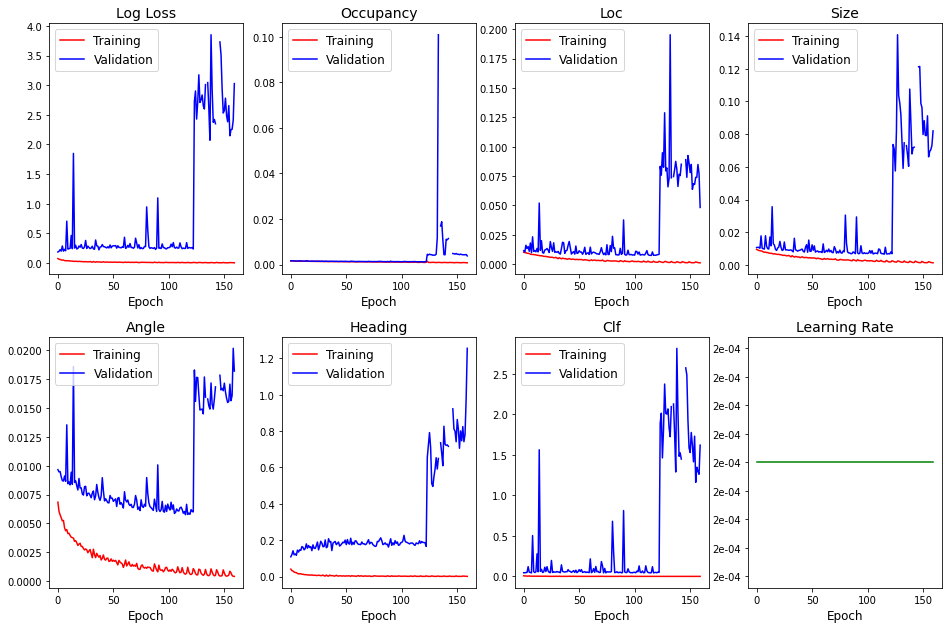

In [18]:
plot_history(results)

In [19]:
n_predictions = 200
eval_gen = SimpleDataGenerator(
    data_reader=data_reader, 
    batch_size=params.batch_size, 
    lidar_files=lidar_files[:n_predictions], 
    label_files=label_files[:n_predictions], 
    calibration_files=calibration_files[:n_predictions]
)

In [20]:
occupancy, position, size, angle, heading, classification = pillar_net.predict(
    eval_gen,
    batch_size=params.batch_size,
    verbose=1
)

50/50 [==============================] - 20s 397ms/step


In [21]:
set_boxes, confidences = [], []
loop_range = occupancy.shape[0] if len(occupancy.shape) == 4 else 1
for i in range(loop_range):
    bbox = generate_bboxes_from_pred(
        occupancy[i], 
        position[i], 
        size[i], 
        angle[i], 
        heading[i],
        classification[i], 
        params.anchor_dims, 
        occ_threshold=0.3
    )
    set_boxes.append(bbox)
    conf = [float(boxes.conf) for boxes in set_boxes[-1]]
    confidences.append(conf)
print('Scene 1: Box predictions with occupancy > occ_thr: ', len(set_boxes[0]))

Scene 1: Box predictions with occupancy > occ_thr:  7


In [26]:
# set_boxes[0:10]

In [27]:
# confidences[0:10]

In [24]:
# NMS
nms_boxes = rotational_nms(set_boxes, confidences, occ_threshold=0.7, nms_iou_thr=0.5)
print('Scene 1: Boxes after NMS with iou_thr: ', len(nms_boxes[0]))

# Do all the further operations on predicted_boxes array, which contains the predicted bounding boxes
gt_gen = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=False)
gt_gen0 = GroundTruthGenerator(data_reader, label_files, calibration_files, network_format=True)

Scene 1: Boxes after NMS with iou_thr:  0


In [25]:
for seq_boxes, gt_label, gt0 in zip(nms_boxes, gt_gen, gt_gen0):
    print("\n---------- New Scenario ---------- ")
    focal_loss_checker(gt0[0], occupancy[0], n_occs=-1)
    print("---------- ------------ ---------- ")
    for gt in gt_label:
        print(gt)
    for pred in seq_boxes:
        print(pred)


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  1  #unmatched pred:  1  occupancy threshold:  0.3849438
---------- ------------ ---------- 
GT | Cls: Pedestrian, x: 8.45, y: -1.72, l: 1.20, w: 0.48, yaw: -1.56

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  10  #unmatched pred:  10  occupancy threshold:  0.285878
---------- ------------ ---------- 
GT | Cls: Truck, x: 69.46, y: 0.13, l: 12.34, w: 2.63, yaw: -3.13
GT | Cls: Car, x: 58.40, y: 17.05, l: 3.69, w: 1.87, yaw: -0.00
GT | Cls: Cyclist, x: 45.89, y: -4.17, l: 2.02, w: 0.60, yaw: -3.12

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  9  #unmatched pred:  9  occupancy threshold:  0.2954141
---------- ------------ ---------- 
GT | Cls: Misc, x: 8.60, y: -3.09, l: 2.37, w: 1.48, yaw: -3.04
GT | Cls: Car, x: 34.44, y: -2.84, l: 4.36, w: 1.58, yaw: 3.13

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  8  #unmatched pred:  8  occupancy threshold:  0.


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  25  #unmatched pred:  25  occupancy threshold:  0.20386723
---------- ------------ ---------- 
GT | Cls: Car, x: 3.19, y: -2.33, l: 3.08, w: 1.44, yaw: -3.06
GT | Cls: Car, x: 10.43, y: 2.37, l: 3.66, w: 1.60, yaw: -3.06
GT | Cls: Car, x: 30.20, y: 1.08, l: 4.08, w: 1.63, yaw: 0.15
GT | Cls: Car, x: 17.53, y: -3.43, l: 2.47, w: 1.59, yaw: -3.06
GT | Cls: Cyclist, x: 44.68, y: -2.36, l: 1.19, w: 0.55, yaw: 0.09
GT | Cls: Car, x: 22.36, y: -3.98, l: 3.22, w: 1.59, yaw: -3.01

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  8  #unmatched pred:  8  occupancy threshold:  0.29719403
---------- ------------ ---------- 
GT | Cls: Truck, x: 37.27, y: -2.80, l: 6.19, w: 2.23, yaw: 0.32
GT | Cls: Car, x: 68.33, y: 4.81, l: 3.64, w: 1.59, yaw: 2.98

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  9  #unmatched pred:  9  occupancy threshold:  0.2954141
---------- ------------ ---------- 


#matched gt:  0  #unmatched gt:  50  #unmatched pred:  50  occupancy threshold:  0.17206216
---------- ------------ ---------- 
GT | Cls: Car, x: 15.17, y: 9.14, l: 4.11, w: 1.63, yaw: 0.02
GT | Cls: Tram, x: 79.63, y: -10.48, l: 23.29, w: 2.37, yaw: -3.08
GT | Cls: Car, x: 21.92, y: 8.90, l: 3.83, w: 1.61, yaw: 0.03
GT | Cls: Car, x: 27.03, y: 8.74, l: 3.40, w: 1.45, yaw: 0.08
GT | Cls: Car, x: 31.85, y: 8.59, l: 4.31, w: 1.71, yaw: 0.04
GT | Cls: Car, x: 41.50, y: 7.93, l: 4.01, w: 1.66, yaw: 0.05
GT | Cls: Car, x: 46.67, y: 7.59, l: 3.90, w: 1.60, yaw: 0.07

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  46  #unmatched pred:  46  occupancy threshold:  0.17440596
---------- ------------ ---------- 
GT | Cls: Car, x: 26.78, y: 0.60, l: 3.67, w: 1.63, yaw: 3.13
GT | Cls: Car, x: 35.35, y: 0.08, l: 4.32, w: 1.69, yaw: -3.14
GT | Cls: Car, x: 7.69, y: -2.73, l: 4.13, w: 1.62, yaw: -3.11
GT | Cls: Car, x: 15.70, y: -2.83, l: 3.26, w: 1.46, yaw: 3.12
GT | Cls: Car, x:


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  11  #unmatched pred:  11  occupancy threshold:  0.26293716
---------- ------------ ---------- 
GT | Cls: Pedestrian, x: 25.07, y: 0.10, l: 1.03, w: 0.87, yaw: 1.10
GT | Cls: Tram, x: 34.85, y: 11.23, l: 6.69, w: 2.81, yaw: -1.94
GT | Cls: Tram, x: 36.68, y: 6.56, l: 3.14, w: 2.80, yaw: -1.94
GT | Cls: Tram, x: 39.58, y: -0.92, l: 12.71, w: 2.79, yaw: -1.94
GT | Cls: Person_sitting, x: 5.56, y: -3.36, l: 0.85, w: 0.56, yaw: 2.55
GT | Cls: Person_sitting, x: 6.87, y: -3.27, l: 0.79, w: 0.64, yaw: 0.51
GT | Cls: Person_sitting, x: 10.63, y: -2.63, l: 0.72, w: 0.68, yaw: -3.13
GT | Cls: Person_sitting, x: 10.63, y: -3.20, l: 0.68, w: 0.57, yaw: 2.38
GT | Cls: Person_sitting, x: 11.72, y: -2.49, l: 0.75, w: 0.63, yaw: -0.27

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  11  #unmatched pred:  11  occupancy threshold:  0.26293716
---------- ------------ ---------- 
GT | Cls: Car, x: 31.63, y: -3.22, l


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  9  #unmatched pred:  9  occupancy threshold:  0.2954141
---------- ------------ ---------- 
GT | Cls: Car, x: 64.01, y: -8.99, l: 4.06, w: 1.55, yaw: -3.05
GT | Cls: Truck, x: 20.23, y: 18.18, l: 10.71, w: 2.81, yaw: -1.79

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  48  #unmatched pred:  48  occupancy threshold:  0.17292869
---------- ------------ ---------- 
GT | Cls: Car, x: 3.14, y: 2.66, l: 4.03, w: 1.59, yaw: -3.14
GT | Cls: Car, x: 12.44, y: 2.90, l: 3.36, w: 1.54, yaw: -3.14
GT | Cls: Car, x: 24.13, y: -0.18, l: 4.38, w: 1.67, yaw: -3.13
GT | Cls: Car, x: 26.90, y: 2.31, l: 3.65, w: 1.59, yaw: -3.12
GT | Cls: Van, x: 12.39, y: 6.47, l: 4.34, w: 1.67, yaw: 0.01
GT | Cls: Car, x: 35.47, y: 5.90, l: 4.16, w: 1.56, yaw: 0.04

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  12  #unmatched pred:  12  occupancy threshold:  0.24044824
---------- ------------ ---------- 
G


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  25  #unmatched pred:  25  occupancy threshold:  0.20386723
---------- ------------ ---------- 
GT | Cls: Car, x: 19.49, y: 0.44, l: 3.32, w: 1.63, yaw: -3.14
GT | Cls: Car, x: 24.03, y: 19.41, l: 4.11, w: 1.85, yaw: -0.01
GT | Cls: Car, x: 25.17, y: 15.81, l: 3.57, w: 1.85, yaw: -0.03

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  3  #unmatched pred:  3  occupancy threshold:  0.3417658
---------- ------------ ---------- 
GT | Cls: Misc, x: 16.38, y: -13.19, l: 2.21, w: 1.10, yaw: -2.23
GT | Cls: Car, x: 18.69, y: -16.14, l: 3.42, w: 1.56, yaw: -2.19
GT | Cls: Car, x: 35.20, y: -27.65, l: 4.21, w: 1.64, yaw: 0.91

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  1  #unmatched pred:  1  occupancy threshold:  0.3849438
---------- ------------ ---------- 
GT | Cls: Pedestrian, x: 9.20, y: -3.63, l: 1.12, w: 0.50, yaw: 1.61

---------- New Scenario ---------- 
#matched gt:  0  #u


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  33  #unmatched pred:  33  occupancy threshold:  0.19404162
---------- ------------ ---------- 
GT | Cls: Car, x: 7.90, y: -3.17, l: 4.10, w: 1.63, yaw: -0.00
GT | Cls: Car, x: 23.62, y: -3.12, l: 4.21, w: 1.64, yaw: 3.13
GT | Cls: Car, x: 29.23, y: 3.84, l: 3.70, w: 1.64, yaw: 0.01
GT | Cls: Car, x: 40.18, y: 1.74, l: 4.54, w: 1.81, yaw: -3.05

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  48  #unmatched pred:  48  occupancy threshold:  0.17292869
---------- ------------ ---------- 
GT | Cls: Car, x: 10.20, y: -4.29, l: 3.51, w: 1.57, yaw: -1.63
GT | Cls: Car, x: 11.32, y: 7.81, l: 4.01, w: 1.57, yaw: 1.51
GT | Cls: Car, x: 12.68, y: -3.96, l: 3.43, w: 1.63, yaw: -1.66
GT | Cls: Car, x: 13.88, y: 8.37, l: 3.34, w: 1.69, yaw: 1.39
GT | Cls: Car, x: 16.18, y: 8.86, l: 4.01, w: 1.62, yaw: 1.37
GT | Cls: Car, x: 18.68, y: 8.65, l: 3.49, w: 1.51, yaw: -1.70
GT | Cls: Car, x: 24.94, y: 10.79, l: 3.75


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  60  #unmatched pred:  60  occupancy threshold:  0.16162662
---------- ------------ ---------- 
GT | Cls: Car, x: 22.32, y: 6.46, l: 3.50, w: 1.54, yaw: -0.01
GT | Cls: Car, x: 26.01, y: -2.60, l: 3.78, w: 1.75, yaw: -3.14
GT | Cls: Car, x: 27.71, y: 6.42, l: 4.02, w: 1.51, yaw: 0.01
GT | Cls: Car, x: 36.23, y: 6.46, l: 4.11, w: 1.65, yaw: -0.00
GT | Cls: Car, x: 42.89, y: 6.71, l: 4.00, w: 1.64, yaw: 0.01
GT | Cls: Van, x: 35.81, y: -24.27, l: 4.73, w: 2.02, yaw: -0.07
GT | Cls: Car, x: 30.04, y: 23.80, l: 3.97, w: 1.60, yaw: -3.14
GT | Cls: Car, x: 29.38, y: 21.12, l: 4.51, w: 1.70, yaw: -3.13

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  30  #unmatched pred:  30  occupancy threshold:  0.19835447
---------- ------------ ---------- 
GT | Cls: Car, x: 6.41, y: 3.70, l: 3.50, w: 1.51, yaw: 0.03
GT | Cls: Car, x: 34.91, y: -2.76, l: 4.67, w: 1.75, yaw: -2.87
GT | Cls: Car, x: 30.73, y: 9.29, l: 3


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  1  #unmatched pred:  1  occupancy threshold:  0.3849438
---------- ------------ ---------- 
GT | Cls: Car, x: 42.08, y: -11.80, l: 4.35, w: 1.72, yaw: 2.60

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  72  #unmatched pred:  72  occupancy threshold:  0.15525533
---------- ------------ ---------- 
GT | Cls: Car, x: 51.11, y: 0.77, l: 3.67, w: 1.63, yaw: 3.13
GT | Cls: Car, x: 29.21, y: 3.37, l: 3.59, w: 1.59, yaw: -0.00
GT | Cls: Car, x: 10.22, y: -2.85, l: 3.70, w: 1.47, yaw: 3.12
GT | Cls: Car, x: 14.77, y: -2.57, l: 3.89, w: 1.64, yaw: 3.11
GT | Cls: Car, x: 18.67, y: -2.47, l: 2.65, w: 1.39, yaw: 3.06
GT | Cls: Car, x: 28.31, y: -2.35, l: 3.79, w: 1.59, yaw: 3.10
GT | Cls: Car, x: 43.59, y: -2.04, l: 4.07, w: 1.57, yaw: -3.13
GT | Cls: Car, x: 33.43, y: -2.28, l: 3.75, w: 1.59, yaw: 3.13
GT | Cls: Car, x: 48.10, y: 12.85, l: 3.94, w: 1.51, yaw: -1.63
GT | Cls: Car, x: 47.97, y: 18.36, l: 4.2


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  60  #unmatched pred:  60  occupancy threshold:  0.16162662
---------- ------------ ---------- 
GT | Cls: Car, x: 17.31, y: 6.44, l: 3.69, w: 1.69, yaw: 1.59
GT | Cls: Car, x: 21.92, y: 6.66, l: 4.07, w: 1.69, yaw: 1.58
GT | Cls: Car, x: 35.65, y: -10.76, l: 4.82, w: 1.99, yaw: -3.08
GT | Cls: Car, x: 36.43, y: -13.49, l: 3.88, w: 1.56, yaw: -3.12
GT | Cls: Car, x: 26.92, y: 6.78, l: 4.12, w: 1.56, yaw: 1.57
GT | Cls: Car, x: 29.59, y: 7.03, l: 3.50, w: 1.59, yaw: 1.54
GT | Cls: Car, x: 32.05, y: 6.95, l: 4.57, w: 1.75, yaw: 1.58

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  19  #unmatched pred:  19  occupancy threshold:  0.2234485
---------- ------------ ---------- 
GT | Cls: Car, x: 35.05, y: 27.31, l: 3.14, w: 1.76, yaw: -2.81
GT | Cls: Car, x: 21.46, y: 0.99, l: 4.50, w: 1.63, yaw: 3.11
GT | Cls: Car, x: 45.79, y: 27.80, l: 2.85, w: 1.64, yaw: -0.02
GT | Cls: Cyclist, x: 42.56, y: -9.01, l:


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  62  #unmatched pred:  62  occupancy threshold:  0.161183
---------- ------------ ---------- 
GT | Cls: Car, x: 46.63, y: -0.10, l: 3.67, w: 1.63, yaw: -3.14
GT | Cls: Car, x: 3.57, y: -2.78, l: 3.79, w: 1.59, yaw: 3.12
GT | Cls: Car, x: 18.88, y: -2.81, l: 4.07, w: 1.57, yaw: -3.13
GT | Cls: Car, x: 8.53, y: -2.84, l: 3.75, w: 1.59, yaw: -3.14
GT | Cls: Car, x: 23.72, y: 11.95, l: 3.94, w: 1.51, yaw: -1.63
GT | Cls: Car, x: 23.73, y: 17.59, l: 4.24, w: 1.56, yaw: -1.55
GT | Cls: Car, x: 23.65, y: -2.95, l: 3.58, w: 1.51, yaw: -3.13
GT | Cls: Car, x: 37.23, y: -3.02, l: 3.93, w: 1.55, yaw: 3.12

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  11  #unmatched pred:  11  occupancy threshold:  0.26293716
---------- ------------ ---------- 
GT | Cls: Car, x: 20.06, y: -0.15, l: 3.20, w: 1.66, yaw: -3.11
GT | Cls: Tram, x: 29.43, y: -7.09, l: 14.86, w: 2.17, yaw: 0.04
GT | Cls: Tram, x: 41.93, y: -7.67,


---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  1  #unmatched pred:  1  occupancy threshold:  0.3849438
---------- ------------ ---------- 
GT | Cls: Pedestrian, x: 7.35, y: 5.13, l: 1.23, w: 0.58, yaw: 1.61

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  17  #unmatched pred:  17  occupancy threshold:  0.22479893
---------- ------------ ---------- 
GT | Cls: Car, x: 21.08, y: 2.44, l: 3.83, w: 1.62, yaw: 0.07
GT | Cls: Car, x: 37.39, y: 0.75, l: 3.67, w: 1.66, yaw: 0.06
GT | Cls: Pedestrian, x: 34.66, y: -9.97, l: 0.55, w: 0.47, yaw: -0.24

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  2  #unmatched pred:  2  occupancy threshold:  0.35170686
---------- ------------ ---------- 
GT | Cls: Pedestrian, x: 12.15, y: -5.56, l: 0.64, w: 0.75, yaw: -0.04
GT | Cls: Cyclist, x: 43.12, y: -4.29, l: 1.93, w: 0.77, yaw: -3.10

---------- New Scenario ---------- 
#matched gt:  0  #unmatched gt:  10  #unmatched pred:  10  occupancy th